In [2]:
import pandas as pd
import geopandas as gpd
import csv
import re
from shapely.geometry import Point

import sys
sys.path.append("..")
import python.full_to_half as htf
import python.write_coordinate_to_csv as wctc
print('Pandas version: ', pd.__version__)
print('Geopandas version: ', gpd.__version__)

Pandas version:  1.4.3
Geopandas version:  0.11.0


In [5]:
#df1 = pd.read_csv(f'./dataset/111_2_a_lvr_land_a.csv', encoding = 'utf-8')
df2 = pd.read_csv(f'./dataset/110_3_a_lvr_land_a.csv', encoding = 'utf-8')
frames = [df, df2]
df = pd.concat(frames)
print(type(df))
df.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25167 entries, 0 to 5539
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   鄉鎮市區           25167 non-null  object 
 1   交易標的           25167 non-null  object 
 2   土地位置建物門牌       25167 non-null  object 
 3   土地移轉總面積平方公尺    25167 non-null  object 
 4   都市土地使用分區       24786 non-null  object 
 5   非都市土地使用分區      6 non-null      object 
 6   非都市土地使用編定      4 non-null      object 
 7   交易年月日          25167 non-null  object 
 8   交易筆棟數          25167 non-null  object 
 9   移轉層次           22889 non-null  object 
 10  總樓層數           22863 non-null  object 
 11  建物型態           25167 non-null  object 
 12  主要用途           22429 non-null  object 
 13  主要建材           22888 non-null  object 
 14  建築完成年月         21682 non-null  object 
 15  建物移轉總面積平方公尺    25167 non-null  object 
 16  建物現況格局-房       25167 non-null  object 
 17  建物現況格局-廳     

In [13]:
filt = (df['鄉鎮市區'] == '中山區') & (df['主要用途'] == '住家用') & (~df['備註'].str.contains('親友', na=False)) & (~df['備註'].str.contains('預售屋', na=False)) & (~df['備註'].str.contains('地上權', na=False)) & (~df['備註'].str.contains('夾層', na=False)) & (df['交易標的'] == '房地(土地+建物)')
pre_df = df.loc[filt,['土地位置建物門牌','交易年月日','建築完成年月','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','電梯','單價元平方公尺']]
pre_df = pre_df.dropna()
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 31 to 5516
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   土地位置建物門牌  1186 non-null   object
 1   交易年月日     1186 non-null   object
 2   建築完成年月    1186 non-null   object
 3   建物現況格局-房  1186 non-null   object
 4   建物現況格局-廳  1186 non-null   object
 5   建物現況格局-衛  1186 non-null   object
 6   電梯        1186 non-null   object
 7   單價元平方公尺   1186 non-null   object
dtypes: object(8)
memory usage: 83.4+ KB


In [14]:
pre_df['屋齡']=pre_df['交易年月日'].str[0:3].astype(int)-pre_df['建築完成年月'].str[0:3].astype(int)

In [15]:
pre_df['交易年份']=pre_df['交易年月日'].str[0:3]

In [16]:
pre_df = pre_df[['交易年份','土地位置建物門牌','屋齡','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','電梯','單價元平方公尺']]
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 31 to 5516
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   交易年份      1186 non-null   object
 1   土地位置建物門牌  1186 non-null   object
 2   屋齡        1186 non-null   int64 
 3   建物現況格局-房  1186 non-null   object
 4   建物現況格局-廳  1186 non-null   object
 5   建物現況格局-衛  1186 non-null   object
 6   電梯        1186 non-null   object
 7   單價元平方公尺   1186 non-null   object
dtypes: int64(1), object(7)
memory usage: 83.4+ KB


In [17]:
pattern = r'[0-9]*?[零一二三四五六七八九十]*?[0-9]*?[零一二三四五六七八九十]{1}[0-9]*?[號]'
pre_df['修正地址'] = pre_df['土地位置建物門牌'].str.contains(pattern,regex=True)
pre_df['土地位置建物門牌'] = htf.h2f(pre_df['土地位置建物門牌'])
pre_df.to_csv('pre_df.csv')

In [19]:
wctc.write('pre_df.csv', 'pre_df_WGS84.csv', 2,9)

progress: 100.0000%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        1186 non-null   int64   
 1   交易年份      1186 non-null   int64   
 2   屋齡        1186 non-null   int64   
 3   建物現況格局-房  1186 non-null   int64   
 4   建物現況格局-廳  1186 non-null   int64   
 5   建物現況格局-衛  1186 non-null   int64   
 6   電梯        1186 non-null   object  
 7   單價元平方公尺   1186 non-null   int64   
 8   geometry  1186 non-null   geometry
dtypes: geometry(1), int64(7), object(1)
memory usage: 83.5+ KB


<AxesSubplot:>

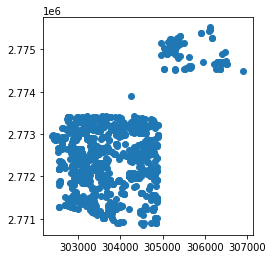

In [20]:
df_final=pd.read_csv('pre_df_WGS84.csv',encoding='utf-8')
geom = [Point(xy) for xy in zip(df_final.lon, df_final.lat)]
crs = {'init': 'epsg:4326'}
gf_final = gpd.GeoDataFrame(df_final, crs=crs, geometry=geom)
gf_final = gf_final.to_crs(epsg=3826)
gf_final['ID'] = gf_final.index
gf_final = gf_final[['ID','交易年份','屋齡','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','電梯','單價元平方公尺','geometry']]
gf_final.info()
gf_final.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        1186 non-null   int64   
 1   交易年份      1186 non-null   int64   
 2   屋齡        1186 non-null   int64   
 3   建物現況格局-房  1186 non-null   int64   
 4   建物現況格局-廳  1186 non-null   int64   
 5   建物現況格局-衛  1186 non-null   int64   
 6   電梯        1186 non-null   object  
 7   單價元平方公尺   1186 non-null   int64   
 8   geometry  1186 non-null   geometry
dtypes: geometry(1), int64(7), object(1)
memory usage: 83.5+ KB


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

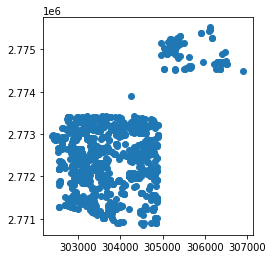

In [21]:
df_house=pd.read_csv('pre_df_WGS84.csv',encoding='utf-8')
geom = [Point(xy) for xy in zip(df_house.lon, df_house.lat)]
crs = {'init': 'epsg:4326'}
gf_house = gpd.GeoDataFrame(df_house, crs=crs, geometry=geom)
gf_house = gf_house.to_crs(epsg=3826)
gf_house['ID'] = gf_house.index
gf_house = gf_house[['ID','交易年份','屋齡','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','電梯','單價元平方公尺','geometry']]
gf_house.info()
gf_house.plot()

<AxesSubplot:>

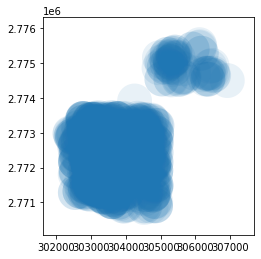

In [22]:
gf_house_buf = gf_house
gf_house_buf['geometry'] = gf_house.buffer(500)
gf_house_buf.plot(alpha=0.1)

In [23]:
df_hospital=pd.read_csv('./dataset/taiwan_hospital_getcoordinates.csv',encoding='utf-8')
geom = [Point(xy) for xy in zip(df_hospital.lon, df_hospital.lat)]
crs = {'init': 'epsg:4326'}
gf_hospital = gpd.GeoDataFrame(df_hospital, crs=crs, geometry=geom)
gf_hospital = gf_hospital.to_crs(epsg=3826)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [24]:
df_cstore=pd.read_csv('./dataset/taiwan_convenience_store_getcoordinates.csv',encoding='utf-8')
geom = [Point(xy) for xy in zip(df_cstore.lon, df_cstore.lat)]
crs = {'init': 'epsg:4326'}
gf_cstore = gpd.GeoDataFrame(df_cstore, crs=crs, geometry=geom)
gf_cstore = gf_cstore.to_crs(epsg=3826)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
# 讀取geojspn
gf_cemetery = gpd.read_file(f'./dataset/cemetery.geojson', encoding = 'utf-8')
gf_cemetery = gf_cemetery.to_crs(epsg=3826)

gf_fire_station = gpd.read_file(f'./dataset/fire_station.geojson', encoding = 'utf-8')
gf_fire_station = gf_fire_station.to_crs(epsg=3826)

gf_fuel = gpd.read_file(f'./dataset/fuel.geojson', encoding = 'utf-8')
gf_fuel = gf_fuel.to_crs(epsg=3826)

gf_library = gpd.read_file(f'./dataset/library.geojson', encoding = 'utf-8')
gf_library = gf_library.to_crs(epsg=3826)

gf_marketplace = gpd.read_file(f'./dataset/marketplace.geojson', encoding = 'utf-8')
gf_marketplace = gf_marketplace.to_crs(epsg=3826)

gf_park = gpd.read_file(f'./dataset/park.geojson', encoding = 'utf-8')
gf_park = gf_park.to_crs(epsg=3826)

gf_parking = gpd.read_file(f'./dataset/parking.geojson', encoding = 'utf-8')
gf_parking = gf_parking.to_crs(epsg=3826)

gf_place_of_worship = gpd.read_file(f'./dataset/place_of_worship.geojson', encoding = 'utf-8')
gf_place_of_worship = gf_place_of_worship.to_crs(epsg=3826)

gf_police = gpd.read_file(f'./dataset/police.geojson', encoding = 'utf-8')
gf_police = gf_police.to_crs(epsg=3826)

gf_school = gpd.read_file(f'./dataset/school.geojson', encoding = 'utf-8')
gf_school = gf_school.to_crs(epsg=3826)

gf_station = gpd.read_file(f'./dataset/station.geojson', encoding = 'utf-8')
gf_station = gf_station.to_crs(epsg=3826)

gf_university = gpd.read_file(f'./dataset/university.geojson', encoding = 'utf-8')
gf_university = gf_university.to_crs(epsg=3826)

In [91]:
gf_university.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 595 entries, 0 to 594
Columns: 103 entries, id to geometry
dtypes: geometry(1), object(102)
memory usage: 478.9+ KB


<AxesSubplot:>

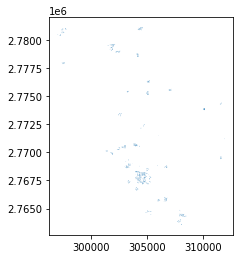

In [92]:
gf_university['geometry'] = gf_university.buffer(0.001)
gf_university.plot()

In [93]:
intersection = gpd.overlay(gf_house_buf,gf_university,  how='intersection', keep_geom_type=True)
#intersection['PARKING_AREA'] = intersection['geometry'].area
intersection_count = intersection.groupby('ID').agg({'id':'count'})
#intersection_count = intersection.groupby('ID').agg({'PARKING_AREA':'sum'})
intersection_count

,id
ID,
6,2
9,3
12,3
20,2
21,17
...,...
1165,3
1166,17
1170,2


In [94]:
gf_final = gf_final.merge(intersection_count,how='left', left_on='ID', right_on='ID')

In [95]:
gf_final.rename(columns={'id': 'NEAR_UNIVERSITY'}, inplace=True)
gf_final.loc[gf_final['NEAR_UNIVERSITY']>0, 'NEAR_UNIVERSITY'] = 1
gf_final['NEAR_UNIVERSITY'] = gf_final['NEAR_UNIVERSITY'].fillna(0)
print(gf_final.info())
gf_final

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1186 entries, 0 to 1185
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ID                1186 non-null   int64   
 1   交易年份              1186 non-null   int64   
 2   屋齡                1186 non-null   int64   
 3   建物現況格局-房          1186 non-null   int64   
 4   建物現況格局-廳          1186 non-null   int64   
 5   建物現況格局-衛          1186 non-null   int64   
 6   電梯                1186 non-null   object  
 7   單價元平方公尺           1186 non-null   int64   
 8   geometry          1186 non-null   geometry
 9   HOSPITAL_COUNT    1186 non-null   float64 
 10  CSTORE_COUNT      1186 non-null   float64 
 11  NEAR_FIRESTATION  1186 non-null   float64 
 12  NEAR_FUEL         1186 non-null   float64 
 13  NEAR_LIBRARY      1186 non-null   float64 
 14  NEAR_MARKET       1186 non-null   float64 
 15  PARK_AREA         1186 non-null   float64 
 16  PARKING_AREA    

,ID,交易年份,屋齡,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,電梯,單價元平方公尺,geometry,HOSPITAL_COUNT,...,NEAR_FUEL,NEAR_LIBRARY,NEAR_MARKET,PARK_AREA,PARKING_AREA,TEMPLE_COUNT,NEAR_POLICE,NEAR_SCHOOL,NEAR_STATION,NEAR_UNIVERSITY
0,0,111,39,3,2,2,有,177928,POINT (304272.573 2773166.123),21.0,...,1.0,1.0,1.0,72085.785107,32795.006527,5,1.0,1.0,0.0,0.0
1,1,111,38,3,2,1,無,293629,POINT (304046.544 2771309.493),46.0,...,1.0,0.0,1.0,7282.581500,7042.418823,8,1.0,1.0,1.0,0.0
2,2,111,51,3,2,2,無,163067,POINT (303577.366 2773376.814),13.0,...,0.0,1.0,0.0,7010.772433,7515.068723,5,1.0,1.0,0.0,0.0
3,3,111,57,4,2,2,無,323197,POINT (303307.719 2773379.679),18.0,...,0.0,1.0,0.0,5124.603136,9466.999924,7,0.0,1.0,0.0,0.0
4,4,111,21,1,1,1,有,279013,POINT (303684.437 2771892.529),71.0,...,1.0,1.0,1.0,14111.007334,6156.016350,16,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1181,110,37,1,1,1,有,177506,POINT (303109.364 2771906.573),76.0,...,1.0,0.0,0.0,47577.083323,24786.855749,13,1.0,1.0,0.0,0.0
1182,1182,110,40,3,1,3,無,165769,POINT (303268.987 2771397.245),50.0,...,1.0,0.0,1.0,45591.717567,30986.535003,8,1.0,1.0,0.0,0.0
1183,1183,110,38,2,2,2,有,214313,POINT (304894.521 2773207.004),22.0,...,0.0,0.0,1.0,19288.341569,5153.367681,4,0.0,1.0,0.0,0.0
1184,1184,110,42,3,2,1,有,201317,POINT (303320.542 2772850.448),54.0,...,0.0,1.0,1.0,11142.787798,5973.154076,15,1.0,1.0,1.0,0.0


In [96]:
gf_final.loc[gf_final['電梯']=='有', '電梯'] = 1
gf_final.loc[gf_final['電梯']=='無', '電梯'] = 0
gf_final

,ID,交易年份,屋齡,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,電梯,單價元平方公尺,geometry,HOSPITAL_COUNT,...,NEAR_FUEL,NEAR_LIBRARY,NEAR_MARKET,PARK_AREA,PARKING_AREA,TEMPLE_COUNT,NEAR_POLICE,NEAR_SCHOOL,NEAR_STATION,NEAR_UNIVERSITY
0,0,111,39,3,2,2,1,177928,POINT (304272.573 2773166.123),21.0,...,1.0,1.0,1.0,72085.785107,32795.006527,5,1.0,1.0,0.0,0.0
1,1,111,38,3,2,1,0,293629,POINT (304046.544 2771309.493),46.0,...,1.0,0.0,1.0,7282.581500,7042.418823,8,1.0,1.0,1.0,0.0
2,2,111,51,3,2,2,0,163067,POINT (303577.366 2773376.814),13.0,...,0.0,1.0,0.0,7010.772433,7515.068723,5,1.0,1.0,0.0,0.0
3,3,111,57,4,2,2,0,323197,POINT (303307.719 2773379.679),18.0,...,0.0,1.0,0.0,5124.603136,9466.999924,7,0.0,1.0,0.0,0.0
4,4,111,21,1,1,1,1,279013,POINT (303684.437 2771892.529),71.0,...,1.0,1.0,1.0,14111.007334,6156.016350,16,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1181,110,37,1,1,1,1,177506,POINT (303109.364 2771906.573),76.0,...,1.0,0.0,0.0,47577.083323,24786.855749,13,1.0,1.0,0.0,0.0
1182,1182,110,40,3,1,3,0,165769,POINT (303268.987 2771397.245),50.0,...,1.0,0.0,1.0,45591.717567,30986.535003,8,1.0,1.0,0.0,0.0
1183,1183,110,38,2,2,2,1,214313,POINT (304894.521 2773207.004),22.0,...,0.0,0.0,1.0,19288.341569,5153.367681,4,0.0,1.0,0.0,0.0
1184,1184,110,42,3,2,1,1,201317,POINT (303320.542 2772850.448),54.0,...,0.0,1.0,1.0,11142.787798,5973.154076,15,1.0,1.0,1.0,0.0


In [98]:
gf_final = gf_final[['交易年份','屋齡','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','電梯','HOSPITAL_COUNT','CSTORE_COUNT','NEAR_UNIVERSITY','NEAR_FIRESTATION','NEAR_FUEL','NEAR_LIBRARY','NEAR_MARKET','PARK_AREA','PARKING_AREA','TEMPLE_COUNT','NEAR_POLICE','NEAR_SCHOOL','NEAR_STATION','單價元平方公尺']]
gf_final.to_csv('final_df.csv')